# Flare Frequency Distributions, power laws, and more

## This notebook illustrates the use of the FFD module `ffd.py`. 

FFD stands for Flare Frequency Distribution. The format of the flare table that is used to inititalize an FFD object shares some of the columns of the `FlareLightCurve.flares` table. 

## This module includes functionality to 

- fit the power law exponent $\alpha$ and intercept $\beta$, 
- plot the resulting function in the cumulative form,
- test if the power law assumption must be rejected, 
- and if the distribution is truncated at the high energy end.

Furthermore, you can make use of the `ed_corr`, `recovery_probability` attributes of the flares in the flare table that you may obtain from performing *injection and recovery of synthetic flares*.

Finally, if your flare table contains contributions from multiple stars that you think generate flares that can be described by the same power law but with different detection thresholds, you can use the `mutliple_stars` keyword to account for this. 

*Note that samples with less than 100-200 flares are to be analysed with caution.*

In [1]:
# Import the main class and a function to generate synthetic flare samples.
from funcs.ffd import FFD, generate_random_power_law_distribution

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 16

## Create an FFD object

Let's create a power law distributed sample of flare energies with exponent $\alpha=-2$

A simple FFD of only one star where we assume to have correct energies, no observational biases, and a clear detection threshold at $ED=10$ s.

In [2]:
# a, b, g, size = energy lower and upper limit, power law exponent +1, number of flares
pwl = generate_random_power_law_distribution(10, 1e3, -1, size=200, seed=80)
simple_ffd = FFD(f=pd.DataFrame({"ed_rec":pwl}))
simple_ffd.f.head()

,ed_rec
0,20.690935
1,32.511053
2,13.645735
3,30.096645
4,99.001434


## Plot the FFD

In [3]:
ed, freq, counts = simple_ffd.ed_and_freq()

Setting ED with new values, size 200.
Setting frequency values with new values, size 200.
Setting frequency adjusted count values with new values, size 200.


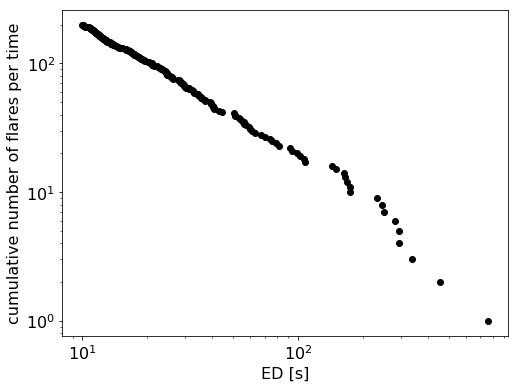

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(ed, freq, c="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time");

## Fit powerlaw

In [5]:
simple_ffd.alpha, simple_ffd.alpha_err = simple_ffd.fit_powerlaw()

In [6]:
simple_ffd.alpha, simple_ffd.alpha_err

(1.963553855895996, 0.08012203082491737)

## Fit intercept to powerlaw with known exponent

In [7]:
betas, simple_ffd.beta, simple_ffd.beta_err = simple_ffd.fit_beta_to_powerlaw()

In [8]:
simple_ffd.beta, simple_ffd.beta_err

(1753.1677389526367, 140.50464845948764)

## Plot the power law

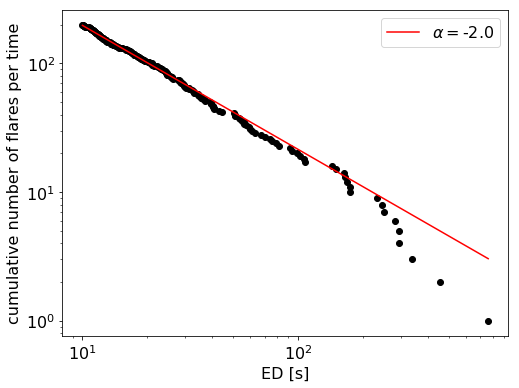

In [9]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.scatter(ed, freq, c="k")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
simple_ffd.plot_powerlaw(ax, c="r",label=fr'$\alpha=$-{simple_ffd.alpha:.1f}')
plt.legend();

## Is this distribution a powerlaw?

In [10]:
simple_ffd.is_powerlaw()

True

## Is this power law distribution truncated at the upper energy limit?

In [11]:
simple_ffd.is_powerlaw_truncated()

False

This distribution is consistent with a power law that is not truncated.

Let's create a truncated version and see if it works:

In [12]:
f=pd.DataFrame({"ed_rec":pwl})
simple_truncated_ffd = FFD(f=f[f.ed_rec<200])#truncate at 200s 
simple_truncated_ffd.alpha = 2.
ed, freq, counts = simple_truncated_ffd.ed_and_freq()

Setting ED with new values, size 191.
Setting frequency values with new values, size 191.
Setting frequency adjusted count values with new values, size 191.


In [13]:
simple_truncated_ffd.is_powerlaw_truncated()

True

*You can play with the truncation limit and sample size to get a feeling for the sensitivity of the test given the sample size.*

## Correct for energy ratio, recovery probability, and detection thresholds

Let's now generate a sample of flares that stem from different stars with different detection thresholds. They shall also have some observational bias captured by the corrected $ED$ `ed_corr` and recovery probability. We choose them to be the same for all stars for simplicity.

In [14]:
# energy upper limit, power law exponent +1, number of flares
a0, b, g, size = 10, 1e8, -1, 30
df = pd.DataFrame()
for a in [60,100,8,90,16,220,110,50,22,80,#65,105,23,96,21,327,117,7,27,85,
          ]: # minimum detected flare energy
    # all flares stem from the same power law distribution
    pwls = generate_random_power_law_distribution(a0, b, g, size=size)
    # introduce a detection threshold
    pwls = pwls[pwls>a]
    df = df.append(pd.DataFrame({
                                # power law distributed detected flare energies
                                "ed_rec":pwls,
                                # true flare energies are typically larger than the detected ones
                                "ed_corr":pwls*2.,
                                #maximum recovery probability is 1, otherwise 0-1
                                "recovery_probability":.7 ,
                                #different targets have different detection thresholds
                                "TIC":a,
                    }))
multi_ffd = FFD(f=df, ID="TIC", tot_obs_time=5.)
multi_ffd.f.head()

,ed_rec,ed_corr,recovery_probability,TIC
0,226.844610,453.689220,0.7,60
1,366.259422,732.518844,0.7,60
2,84.747559,169.495117,0.7,60
3,72.411908,144.823816,0.7,60
0,107.607129,215.214257,0.7,100


#### Plot the distributions using the different correction steps:

1. No correction. Just `ed_rec` vs. frequency
2. Correct the ED ratio between injected and recovered flares, i.e., use the `ed_corr` column and the frequency. This is done by setting `energy_correction = True`
3. Now use `ed_corr` and correct the individual frequencies of each flare by `recovery_probability`. This is done by adding the `recovery_probability_correction = True` keyword.
4. Finally, average each portion of the FFD by the number of stars that contribute to it by adding another keyword: `multiple_stars = True`

Setting ED with new values, size 89.
Setting frequency values with new values, size 89.
Setting frequency adjusted count values with new values, size 89.
Setting ED with new values, size 89.
Setting frequency values with new values, size 89.
Setting frequency adjusted count values with new values, size 89.
Setting ED with new values, size 89.
Setting frequency values with new values, size 89.
Setting frequency adjusted count values with new values, size 89.
Setting ED with new values, size 89.
Setting frequency values with new values, size 89.
Setting frequency adjusted count values with new values, size 371.


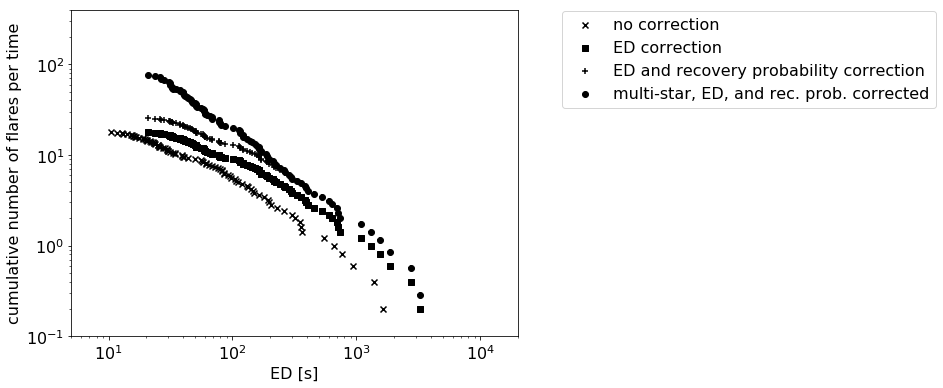

In [15]:
fig, ax = plt.subplots(1,figsize=(8,6))


ed, freq, counts = multi_ffd.ed_and_freq()

ax.scatter(ed, freq, c="k", marker="x",label="no correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True)
ax.scatter(ed, freq, c="k",marker="s", label="ED correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True)

ax.scatter(ed, freq, c="k",marker="+", label="ED and recovery probability correction")

ed, freq, counts = multi_ffd.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True,
                                        multiple_stars=True)

ax.scatter(ed, freq, c="k", label="multi-star, ED, and rec. prob. corrected")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per time")
ax.set_xlim(5,2e4)
ax.set_ylim(.1,4e2)
plt.legend(loc=(1.1,.7));

### Fit $\alpha$ using the MLE method from Maschberger and Kroupa (2009).
[[MNRAS](https://academic.oup.com/mnras/article/395/2/931/1747409), [ArXiv](https://arxiv.org/abs/0905.0474)]

In [16]:
multi_ffd.fit_powerlaw(count_ed=True)
multi_ffd.alpha, multi_ffd.alpha_err

(1.883210175506509, 0.04643983656461689)

*The uncertainty on $\alpha$ should not be used here, because the sample was blown up artificially at the low energy end to compensate for the different detection thresholds when setting the `multiple_stars` flag.*

Now fit $\beta$ simply using the least-squares method:

In [17]:
betas, multi_ffd.beta, multi_ffd.betas_err = multi_ffd.fit_beta_to_powerlaw()
multi_ffd.beta, multi_ffd.betas_err

(1056.168081905065, 49.852617791719744)

Finally, show the resulting fit, and compare to the intrinsic distribution:

Setting ED with new values, size 89.
Setting frequency values with new values, size 89.
Setting frequency adjusted count values with new values, size 371.


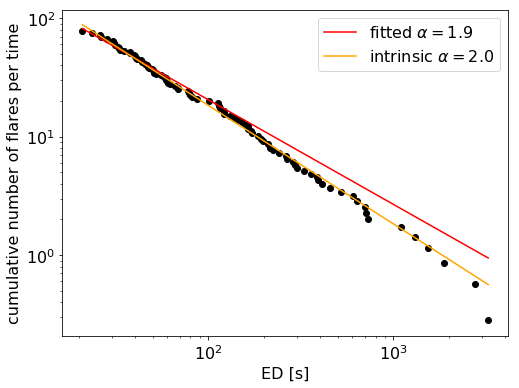

In [18]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.scatter(multi_ffd.ed, multi_ffd.freq, c="k")
multi_ffd.plot_powerlaw(ax,c="r",label=fr"fitted $\alpha={multi_ffd.alpha:.1f}$")

#overplot the intrinsic distribution-------------------------------------------------
multi_ffd2 = FFD(f=df, ID="TIC", tot_obs_time=5.)
ed, freq, counts = multi_ffd2.ed_and_freq(energy_correction=True,
                                         recovery_probability_correction=True,
                                        multiple_stars=True)
multi_ffd2.alpha, multi_ffd2.alpha_err = -g+1, .1
betas, multi_ffd2.beta, multi_ffd2.betas_err = multi_ffd2.fit_beta_to_powerlaw()
multi_ffd2.plot_powerlaw(ax,c="orange",label=fr"intrinsic $\alpha={multi_ffd2.alpha:.1f}$")
#--------------------------------------------------------------------------------------

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per time")
plt.legend();

#### Let's test if the two solutions are consistent with a power law.

In [19]:
multi_ffd.is_powerlaw(count_ed=True), multi_ffd2.is_powerlaw(count_ed=True)

(True, True)

The should not be truncated because we set the upper limit to very high energies:

In [20]:
multi_ffd.is_powerlaw_truncated(count_ed=True), multi_ffd2.is_powerlaw_truncated(count_ed=True)

(False, False)